In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture



In [2]:
iris = load_iris()
features = iris.data  
labels = iris.target  
features = StandardScaler().fit_transform(features)  
from sklearn.preprocessing import StandardScaler
features = StandardScaler().fit_transform(features)


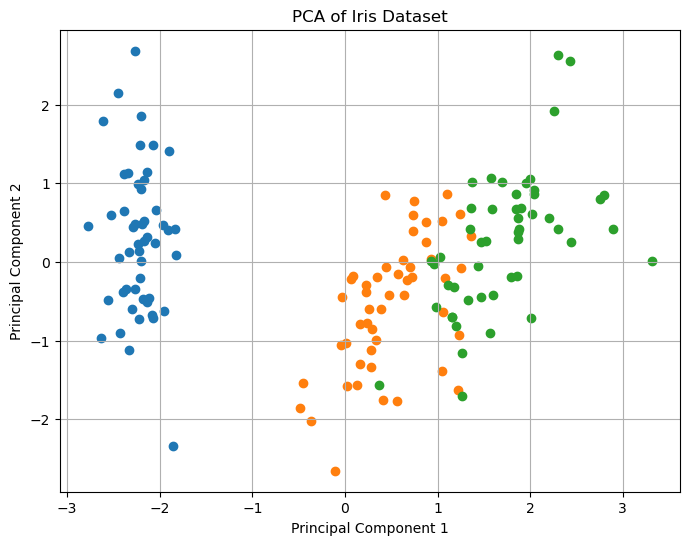

In [3]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)
plt.figure(figsize=(8, 6))
for i, label in enumerate(np.unique(labels)):
    plt.scatter(X_pca[labels == label, 0], X_pca[labels == label, 1], label=iris.target_names[label])
plt.title('PCA of Iris Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

In [4]:
class GaussianMixtureEM:
    def __init__(self, n_components, max_iter=100, tol=1e-5):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.trajectory = []  
        self.log_likelihoods = []  

    def fit(self, X):
        n_samples, n_features = X.shape
        np.random.seed(100)  
        self.means = np.random.rand(self.n_components, n_features)
        self.covariances = np.array([np.eye(n_features)] * self.n_components) * 0.1
        if self.n_components == 3:
            self.weights = np.array([0.7, 0.2, 0.1])
        else:
            self.weights = np.full(self.n_components, 1.0 / self.n_components)
        
        self.trajectory.append(self.means.copy())  # Record initial means

        log_likelihood = -np.inf

        for iteration in range(self.max_iter):
 
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)
            new_log_likelihood = self._compute_log_likelihood(X)
            self.log_likelihoods.append(new_log_likelihood)
            if abs(new_log_likelihood - log_likelihood) < self.tol:
                print(f"Convergence reached at iteration {iteration + 1}.")
                break
            log_likelihood = new_log_likelihood
            self.trajectory.append(self.means.copy())

    def _e_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * self._gaussian_pdf(X, self.means[k], self.covariances[k])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def _m_step(self, X, responsibilities):
        n_samples, n_features = X.shape
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / n_samples
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        for k in range(self.n_components):
            X_centered = X - self.means[k]
            self.covariances[k] = (responsibilities[:, k][:, np.newaxis] * X_centered).T @ X_centered / Nk[k]
            self.covariances[k] += 1e-6 * np.eye(n_features)  # Regularization term

    def _gaussian_pdf(self, X, mean, covariance):
        n_features = X.shape[1]
        try:
            det = np.linalg.det(covariance)
            if det <= 0:
                det = 1e-6
            inv = np.linalg.inv(covariance)
        except np.linalg.LinAlgError:
            det = 1e-6
            inv = np.linalg.pinv(covariance)

        norm_factor = 1 / (np.sqrt((2 * np.pi) ** n_features * det))
        diff = X - mean
        exponent = -0.5 * np.sum(diff @ inv * diff, axis=1)
        return norm_factor * np.exp(exponent)

    def predict(self, X):
        responsibilities = self._e_step(X)
        return np.argmax(responsibilities, axis=1)

    def _compute_log_likelihood(self, X):
        log_likelihood = 0 + 1e-10  # Avoid log(0)
        for k in range(self.n_components):
            log_likelihood += self.weights[k] * self._gaussian_pdf(X, self.means[k], self.covariances[k])
        return np.sum(np.log(log_likelihood))


Convergence reached at iteration 24.


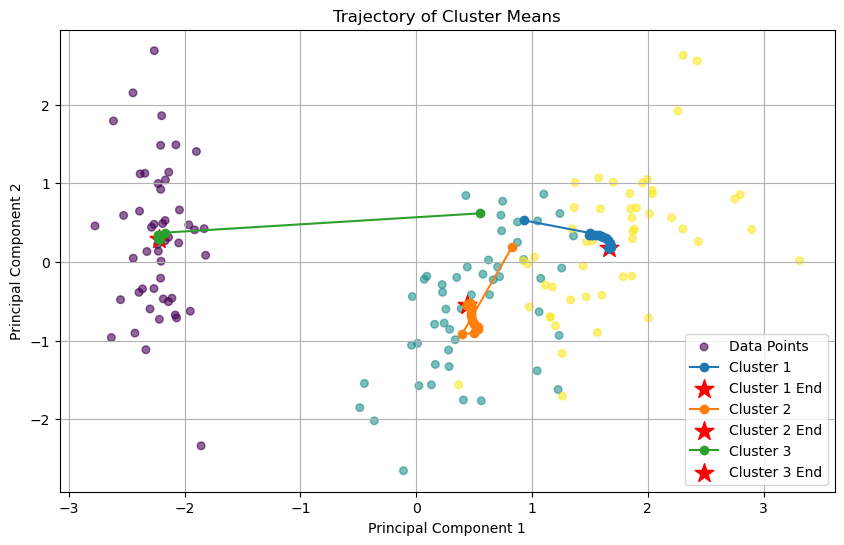

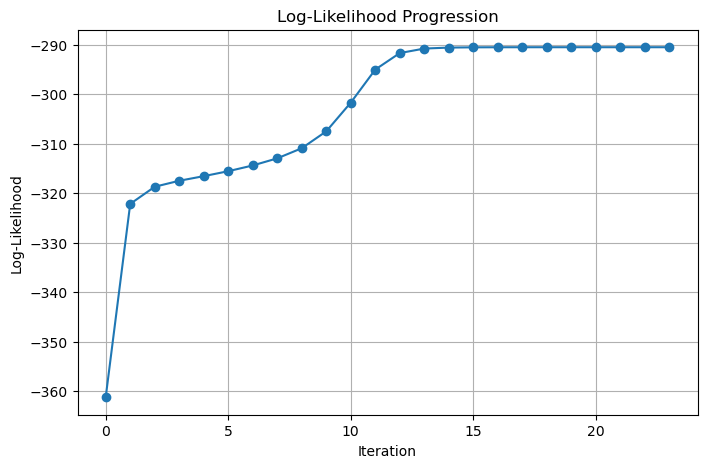

In [5]:
em_model = GaussianMixtureEM(n_components=3, max_iter=100)
em_model.fit(features)

pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
trajectory_2d = [pca.transform(means) for means in em_model.trajectory]

plt.figure(figsize=(10, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis', s=30, alpha=0.6, label='Data Points')
for i, cluster_trajectory in enumerate(np.array(trajectory_2d).transpose(1, 0, 2)):
    plt.plot(cluster_trajectory[:, 0], cluster_trajectory[:, 1], marker='o', label=f'Cluster {i+1}')
    plt.scatter(cluster_trajectory[-1, 0], cluster_trajectory[-1, 1], marker='*', s=200, c='red', label=f'Cluster {i+1} End')
plt.title('Trajectory of Cluster Means')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(em_model.log_likelihoods, marker='o')
plt.title('Log-Likelihood Progression')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()


In [6]:
from scipy.special import logsumexp

class VariationalInferenceGMM:
    def __init__(self, n_components, max_iter=100, tol=1e-5):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.variational_params = None
        self.log_likelihoods = []

    def fit(self, X):
        n_samples, n_features = X.shape
        np.random.seed(100) 

        self.means = np.random.rand(self.n_components, n_features)
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.weights = np.full(self.n_components, 1.0 / self.n_components)
        if(self.n_components==3):
            self.weights = np.array([0.7,0.2,0.1])
        self.variational_params = np.random.dirichlet(alpha=[1]*self.n_components, size=n_samples)

        log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            responsibilities = self._e_step(X)
            self._m_step(X, responsibilities)
            new_log_likelihood = self._compute_elbo(X, responsibilities)
            self.log_likelihoods.append(new_log_likelihood)
            if abs(new_log_likelihood - log_likelihood) < self.tol:
                print("Convergence reached.")
                break
            log_likelihood = new_log_likelihood

            yield responsibilities  

    def _e_step(self, X):
        n_samples = X.shape[0]
        log_resp = np.zeros((n_samples, self.n_components))
        for k in range(self.n_components):
            log_resp[:, k] = np.log(self.weights[k] + 1e-10) + self._log_gaussian_pdf(X, self.means[k], self.covariances[k])
        log_resp -= log_resp.max(axis=1, keepdims=True)  
        responsibilities = np.exp(log_resp)
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        self.variational_params = responsibilities
        return responsibilities

    def _m_step(self, X, responsibilities):
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / responsibilities.shape[0]
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        for k in range(self.n_components):
            X_centered = X - self.means[k]
            covariance = (responsibilities[:, k][:, np.newaxis] * X_centered).T @ X_centered / Nk[k]
            self.covariances[k] = covariance + 1e-6 * np.eye(X.shape[1])

    def _log_gaussian_pdf(self, X, mean, covariance):
        n_features = X.shape[1]
        try:
            det = np.linalg.det(covariance)
            if det <= 0:
                det = 1e-6
            inv = np.linalg.inv(covariance)
        except np.linalg.LinAlgError:
            det = 1e-6
            inv = np.linalg.pinv(covariance)

        norm_factor = -0.5 * (np.log(det) + n_features * np.log(2 * np.pi))
        diff = X - mean
        exponent = -0.5 * np.sum(diff @ inv * diff, axis=1)
        return norm_factor + exponent

    def _compute_elbo(self, X, responsibilities):
        log_probs = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            log_probs[:, k] = np.log(self.weights[k] + 1e-10) + self._log_gaussian_pdf(X, self.means[k], self.covariances[k])
        log_likelihood = np.sum(logsumexp(log_probs, axis=1))
        return log_likelihood


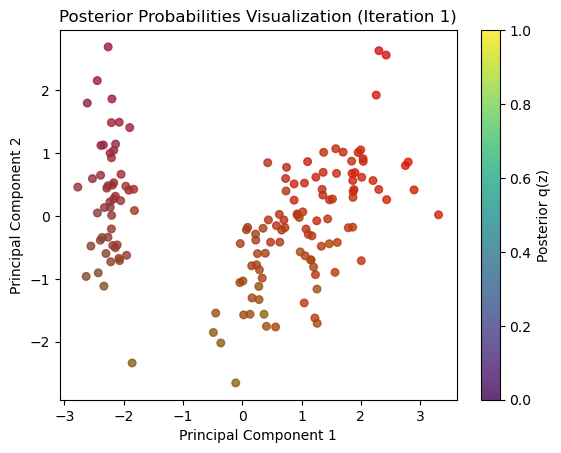

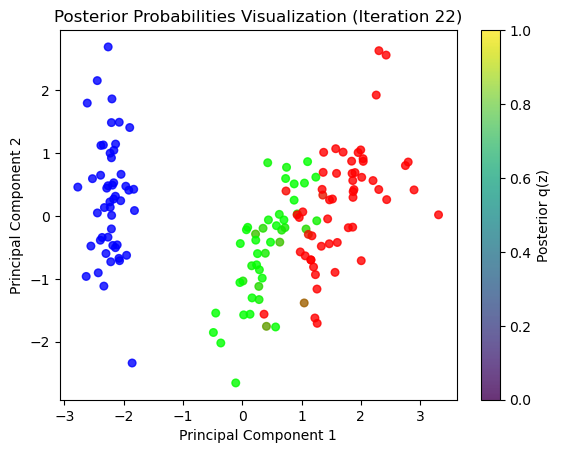

Convergence reached.


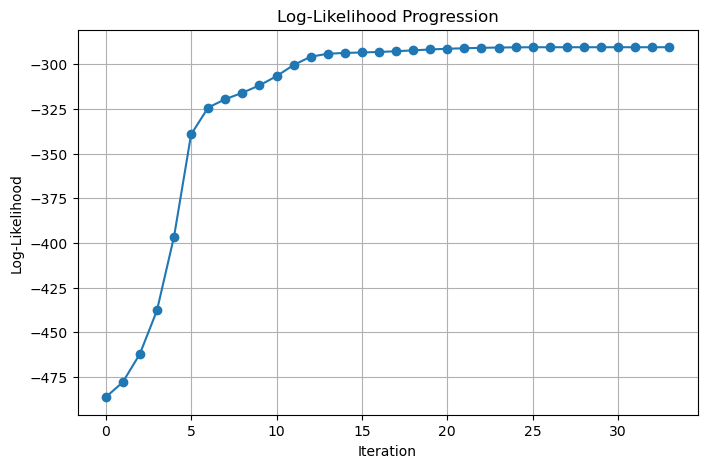

In [7]:

vi_model = VariationalInferenceGMM(n_components=3, max_iter=100)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)

for iteration, responsibilities in enumerate(vi_model.fit(features)):
    if iteration % 21 != 0 or iteration == vi_model.max_iter :
        continue
    colors = responsibilities
    
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=colors, s=30, alpha=0.8)

    plt.title(f'Posterior Probabilities Visualization (Iteration {iteration + 1})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Posterior q(z)')
    plt.pause(0.5) 
plt.figure(figsize=(8, 5))
plt.plot(vi_model.log_likelihoods, marker='o')
plt.title('Log-Likelihood Progression')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()


In [8]:
class GMMGibbsSampler:
    def __init__(self, n_components, max_iter=100):
        self.n_components = n_components
        self.max_iter = max_iter
        self.cluster_assignments = None
        self.means = None
        self.covariances = None
        self.mixing_coefficients = None

    def fit(self, X):
        n_samples, n_features = X.shape
        np.random.seed(100)  
        self.cluster_assignments = np.random.randint(0, self.n_components, size=n_samples)
        self.means = np.random.rand(self.n_components, n_features)
        self.covariances = np.array([np.eye(n_features)] * self.n_components)
        self.mixing_coefficients = np.ones(self.n_components) / self.n_components
        
        for iteration in range(self.max_iter):
            for i in range(n_samples):
                self.cluster_assignments[i] = self._sample_cluster(X[i])
            self._update_parameters(X)

    def _sample_cluster(self, x_i):
        posterior = np.zeros(self.n_components)
        for k in range(self.n_components):
            posterior[k] = self.mixing_coefficients[k] * self._gaussian_pdf(x_i, self.means[k], self.covariances[k])
        posterior /= posterior.sum() 
        return np.random.choice(self.n_components, p=posterior)

    def _update_parameters(self, X):
        n_samples, n_features = X.shape
        for k in range(self.n_components):
            cluster_points = X[self.cluster_assignments == k]
            Nk = cluster_points.shape[0]
            if Nk > 0:
                self.means[k] = cluster_points.mean(axis=0)
                self.covariances[k] = np.cov(cluster_points, rowvar=False) + np.eye(n_features) * 1e-6  
                self.mixing_coefficients[k] = Nk / n_samples

    def _gaussian_pdf(self, x, mean, covariance):
        n_features = x.shape[0]
        det = np.linalg.det(covariance)
        inv = np.linalg.inv(covariance)
        norm_factor = 1 / (np.sqrt((2 * np.pi) ** n_features * det))
        diff = x - mean
        return norm_factor * np.exp(-0.5 * np.dot(np.dot(diff, inv), diff))

    def predict(self):
        return self.cluster_assignments

In [9]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import wishart, multivariate_normal, dirichlet

class GMMGibbsSampler:
    def __init__(self, n_components, max_iter=100, tol=1e-4, random_state=100):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_assignments = None
        self.means = None
        self.covariances = None
        self.mixing_coefficients = None
        self.log_likelihoods = []
        
        np.random.seed(100)

        self.alpha = 1.0
        self.m0 = None       
        self.V0 = None       
        self.S0 = None      
        self.v0 = None       
    def fit(self, X):
        N, D = X.shape
        self.m0 = np.random.randn(D)*2
        self.V0 = np.eye(D) * 0.3
        self.S0 = np.eye(D) * 0.1
        self.v0 = D+2
        self.cluster_assignments = np.random.randint(0, self.n_components, size=N)
        self.means = []
        self.covariances = []
        for _ in range(self.n_components):
            Sigma_k = self._inverse_wishart(self.v0, self.S0)
            mu_k = multivariate_normal.rvs(mean=self.m0, cov=self.V0)
            self.means.append(mu_k)
            self.covariances.append(Sigma_k)

        self.means = np.array(self.means)
        self.covariances = np.array(self.covariances)
        self.mixing_coefficients = np.random.dirichlet([self.alpha]*self.n_components)

        prev_ll = -np.inf
        for iteration in range(self.max_iter):
            self._sample_cluster_assignments(X)
            self._sample_mixing_coefficients(X)
            self._sample_parameters(X)
            current_ll = self._log_likelihood(X)
            self.log_likelihoods.append(current_ll)

            if iteration > 0 and np.abs(current_ll - prev_ll) < self.tol:
                print(f"Converged at iteration {iteration+1}.")
                break
            prev_ll = current_ll

    def _sample_cluster_assignments(self, X):
        N, D = X.shape
        for i in range(N):
            posterior = np.zeros(self.n_components)
            for k in range(self.n_components):
                posterior[k] = self.mixing_coefficients[k] * multivariate_normal.pdf(X[i], mean=self.means[k], cov=self.covariances[k])+1e-10
            posterior /= posterior.sum()
            self.cluster_assignments[i] = np.random.choice(self.n_components, p=posterior)

    def _sample_parameters(self, X):
        D = X.shape[1]
        for k in range(self.n_components):
            X_k = X[self.cluster_assignments == k]
            Nk = X_k.shape[0]
            if Nk > 0:
                x_bar_k = X_k.mean(axis=0)
                S_k = np.sum([(x - x_bar_k).reshape(-1,1)@(x - x_bar_k).reshape(1,-1) for x in X_k], axis=0)
                v_n = self.v0 + Nk
                mean_diff = (x_bar_k - self.m0).reshape(-1,1)
                S0_star = self.S0 + S_k 
                Sigma_k = self._inverse_wishart(v_n, S0_star)
                V0_inv = np.linalg.inv(self.V0)
                Sigma_k_inv = np.linalg.inv(Sigma_k)
                V_n_inv = V0_inv + Nk * Sigma_k_inv+1e-10*np.eye(D)
                V_n = np.linalg.inv(V_n_inv)
                m_n = V_n @ (Sigma_k_inv @ (Nk * x_bar_k) + V0_inv @ self.m0)
                mu_k = multivariate_normal.rvs(mean=m_n, cov=V_n)

                self.means[k] = mu_k
                self.covariances[k] = Sigma_k
            else:
                Sigma_k = self._inverse_wishart(self.v0, self.S0)
                mu_k = multivariate_normal.rvs(mean=self.m0, cov=self.V0)
                self.means[k] = mu_k
                self.covariances[k] = Sigma_k

    def _sample_mixing_coefficients(self, X):
        Nk = np.array([np.sum(self.cluster_assignments == k) for k in range(self.n_components)])
        self.mixing_coefficients = dirichlet.rvs(self.alpha + Nk).flatten()

    def _inverse_wishart(self, df, scale):
        Y = wishart.rvs(df=df, scale=np.linalg.inv(scale))
        return np.linalg.inv(Y)


    def _log_likelihood(self, X):
        N = X.shape[0]
        ll = 0
        for i in range(N):
            val = 0
            for k in range(self.n_components):
                val += self.mixing_coefficients[k] * multivariate_normal.pdf(X[i], mean=self.means[k], cov=self.covariances[k])
            ll += np.log(val + 1e-300)
        return ll

    def predict(self):
        return self.cluster_assignments


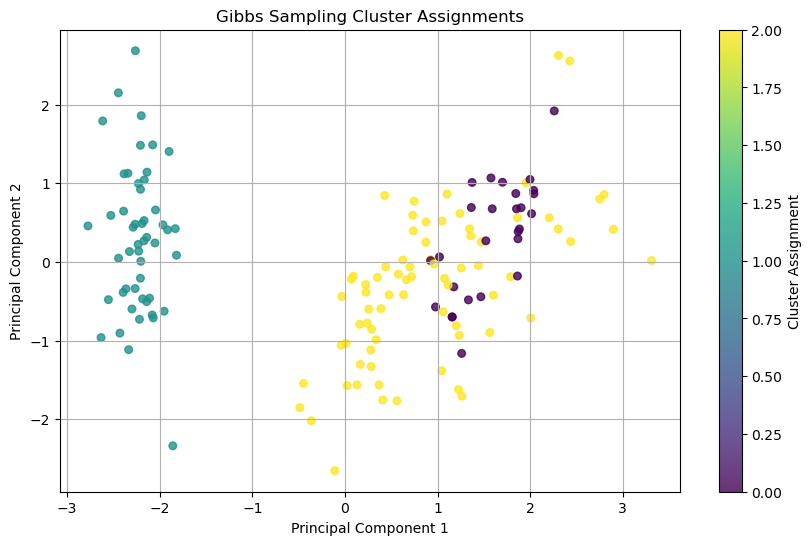

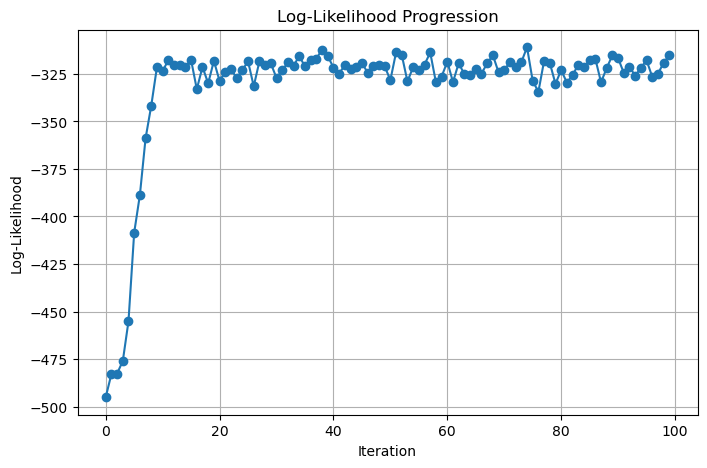

In [10]:
gibbs_model = GMMGibbsSampler(n_components=3, max_iter=100)
gibbs_model.fit(features)
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
cluster_assignments = gibbs_model.predict()
plt.figure(figsize=(10, 6))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=cluster_assignments, cmap='viridis', s=30, alpha=0.8)
plt.title('Gibbs Sampling Cluster Assignments')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Assignment')
plt.grid()
plt.show()
plt.figure(figsize=(8, 5))
plt.plot(gibbs_model.log_likelihoods, marker='o')
plt.title('Log-Likelihood Progression')
plt.xlabel('Iteration')
plt.ylabel('Log-Likelihood')
plt.grid()
plt.show()

In [11]:
def rand_index(true_labels, predicted_labels):
    n = len(true_labels)
    a = 0  
    b = 0  
    for i in range(n):
        for j in range(i + 1, n):
            if true_labels[i] == true_labels[j] and predicted_labels[i] == predicted_labels[j]:
                a += 1
            elif true_labels[i] != true_labels[j] and predicted_labels[i] != predicted_labels[j]:
                b += 1
    
    return (a + b) / (n * (n - 1) / 2)

In [12]:
from sklearn.metrics import adjusted_rand_score
def calculate_rand_index(true_labels, predicted_labels):
    return adjusted_rand_score(true_labels, predicted_labels)

em_model = GaussianMixtureEM(n_components=3, max_iter=100)
em_model.fit(features)
predicted_labels = em_model.predict(features)
ari = rand_index(labels, predicted_labels)
print(f"Rand Index : {ari:.4f} (EM algorithm)")
vi_model = VariationalInferenceGMM(n_components=3, max_iter=100)
for _ in vi_model.fit(features): 
    pass
predicted_labels = np.argmax(vi_model.variational_params, axis=1) 
rand_index_vi= rand_index(labels, predicted_labels)
print(f" Index (ARI): {rand_index_vi:.4f} (Variational Inference)")
gibbs_model = GMMGibbsSampler(n_components=3, max_iter=100)
gibbs_model.fit(features)

cluster_assignments = gibbs_model.predict()
rand_index_gibbs = rand_index(labels, cluster_assignments)
print(f"Rand Index (Gibbs): {rand_index_gibbs:.4f}")


Convergence reached at iteration 24.
Rand Index : 0.9575 (EM algorithm)
Convergence reached.
 Index (ARI): 0.9575 (Variational Inference)
Rand Index (Gibbs): 0.8415


In [13]:
def compute_bic_em(features, max_clusters=10):
    bics = []
    ks = range(1, max_clusters + 1)
    for k in ks:
        em_model = GaussianMixtureEM(n_components=k)
        em_model.fit(features)
        log_likelihood = em_model._compute_log_likelihood(features)
        n_samples, n_features = features.shape
        p = k * n_features + k * n_features * (n_features + 1) / 2 + (k - 1)
        bic = -2 * log_likelihood + p * np.log(n_samples)
        bics.append(bic)
    return ks, bics


Convergence reached at iteration 2.
Convergence reached at iteration 17.
Convergence reached at iteration 24.
Convergence reached at iteration 73.
Convergence reached at iteration 46.
Convergence reached at iteration 44.
Convergence reached at iteration 49.
Convergence reached at iteration 59.
Convergence reached at iteration 82.


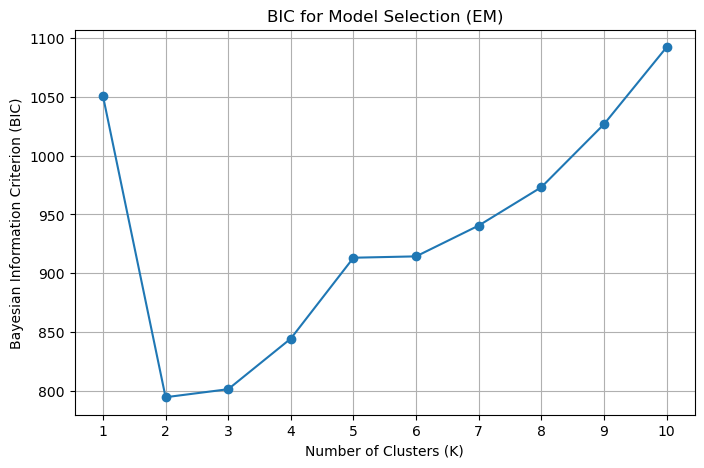

Optimal number of clusters (K) using BIC: 2


In [14]:
max_clusters = 10
ks, bics = compute_bic_em(features, max_clusters=max_clusters)
plt.figure(figsize=(8, 5))
plt.plot(ks, bics, marker='o')
plt.title('BIC for Model Selection (EM)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Bayesian Information Criterion (BIC)')
plt.xticks(ks)
plt.grid()
plt.show()
optimal_k = ks[np.argmin(bics)]
print(f"Optimal number of clusters (K) using BIC: {optimal_k}")


bic for vi

In [15]:
def calculate_num_parameters(n_components, n_features):
    weights = n_components - 1
    means = n_components * n_features
    covariances = n_components * (n_features * (n_features + 1) // 2)
    return weights + means + covariances

def calculate_bic(log_likelihood, n_parameters, n_samples):
    return n_parameters * np.log(n_samples) - 2 * log_likelihood

def model_selection_bic(X, max_clusters=10, max_iter=100, tol=1e-5):
    bic_scores = {}
    n_samples, n_features = X.shape

    for n_components in range(1, max_clusters + 1):
        gmm = VariationalInferenceGMM(n_components=n_components, max_iter=max_iter, tol=tol)
        responsibilities_generator = gmm.fit(X)
        for _ in responsibilities_generator:
            pass  
        final_log_likelihood = gmm.log_likelihoods[-1] if gmm.log_likelihoods else -np.inf
        n_parameters = calculate_num_parameters(n_components, n_features)
        bic = calculate_bic(final_log_likelihood, n_parameters, n_samples)
        bic_scores[n_components] = bic
        print(f"Number of Components: {n_components}, BIC: {bic:.2f}\n")
    optimal_n_components = min(bic_scores, key=bic_scores.get)
    print(f"Optimal number of clusters (K) based on BIC: {optimal_n_components}")
    
    return bic_scores, optimal_n_components
def plot_bic(bic_scores):
    ks = list(bic_scores.keys())
    bics = list(bic_scores.values())
    plt.figure(figsize=(8, 5))
    plt.plot(ks, bics, marker='o')
    plt.title('BIC for Variational Inference GMM on Iris Dataset')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Bayesian Information Criterion (BIC)')
    plt.xticks(ks)
    plt.grid(True)
    plt.show()

Convergence reached.
Number of Components: 1, BIC: 1050.67

Convergence reached.
Number of Components: 2, BIC: 794.71

Convergence reached.
Number of Components: 3, BIC: 801.53

Convergence reached.
Number of Components: 4, BIC: 847.50

Convergence reached.
Number of Components: 5, BIC: 913.57

Convergence reached.
Number of Components: 6, BIC: 959.30

Convergence reached.
Number of Components: 7, BIC: 899.39

Number of Components: 8, BIC: 995.18

Convergence reached.
Number of Components: 9, BIC: 982.59

Number of Components: 10, BIC: 1034.50

Optimal number of clusters (K) based on BIC: 2


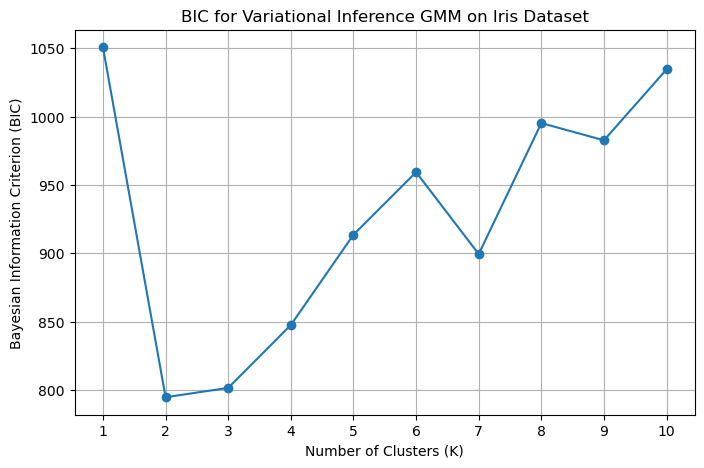

In [16]:
max_clusters = 10
bic_scores, optimal_k = model_selection_bic(features, max_clusters=max_clusters)
plot_bic(bic_scores)
optimal_gmm = VariationalInferenceGMM(n_components=optimal_k, max_iter=100, tol=1e-5)
responsibilities_generator = optimal_gmm.fit(features)


bic for gibbs sampling

In [17]:
def compute_bic_gibbs_sampler(X, max_clusters=10, max_iter=100, tol=1e-4, random_state=100):
    bic_scores = []
    ks = list(range(1, max_clusters + 1))
    n_samples, n_features = X.shape
    for k in ks:
        print(f"Fitting GMM with {k} components...")
        em_model = GMMGibbsSampler(n_components=k, max_iter=max_iter, tol=tol, random_state=random_state)
        em_model.fit(X)
        log_likelihood = em_model._log_likelihood(X)
        n_parameters = calculate_num_parameters(k, n_features)
        bic = n_parameters * np.log(n_samples) - 2 * log_likelihood
        bic_scores.append(bic)
        print(f"Number of Components: {k}, BIC: {bic:.2f}\n")
    optimal_k = ks[np.argmin(bic_scores)]
    print(f"Optimal number of clusters (K) based on BIC: {optimal_k}")
    return ks, bic_scores, optimal_k
def calculate_num_parameters(n_components, n_features):
    weights = n_components - 1
    means = n_components * n_features
    covariances = n_components * (n_features * (n_features + 1) // 2)
    return weights + means + covariances

def plot_bic(ks, bic_scores):
    plt.figure(figsize=(8, 5))
    plt.plot(ks, bic_scores, marker='o', linestyle='-', color='b')
    plt.title('BIC for Gibbs Sampler-based GMM on Iris Dataset')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Bayesian Information Criterion (BIC)')
    plt.xticks(ks)
    plt.grid(True)
    plt.show()

Fitting GMM with 1 components...
Number of Components: 1, BIC: 1058.01

Fitting GMM with 2 components...
Number of Components: 2, BIC: 828.94

Fitting GMM with 3 components...
Number of Components: 3, BIC: 850.78

Fitting GMM with 4 components...
Number of Components: 4, BIC: 959.15

Fitting GMM with 5 components...
Number of Components: 5, BIC: 1020.01

Fitting GMM with 6 components...
Number of Components: 6, BIC: 1100.43

Fitting GMM with 7 components...
Number of Components: 7, BIC: 1337.72

Fitting GMM with 8 components...
Number of Components: 8, BIC: 1243.07

Fitting GMM with 9 components...
Number of Components: 9, BIC: 1269.95

Fitting GMM with 10 components...
Number of Components: 10, BIC: 1368.48

Optimal number of clusters (K) based on BIC: 2


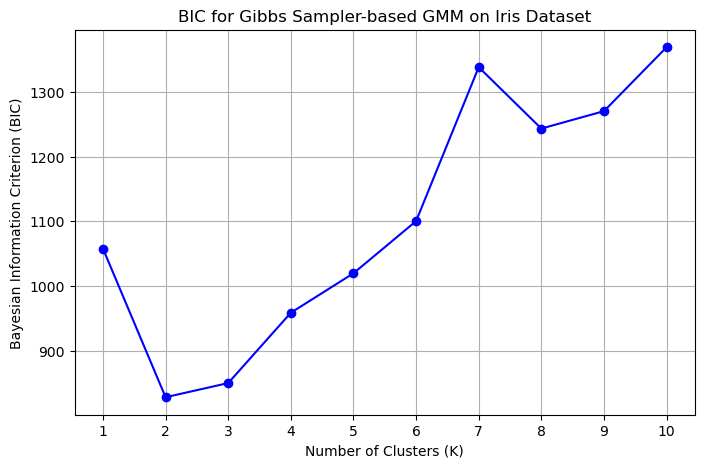

Fitting the optimal GMM with 2 components...


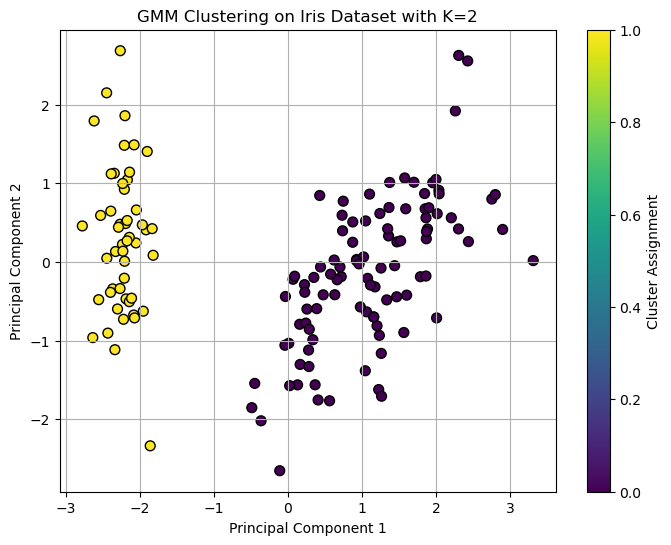

In [18]:
max_clusters = 10
ks, bics, optimal_k = compute_bic_gibbs_sampler(features, max_clusters=max_clusters)
plot_bic(ks, bics)
print(f"Fitting the optimal GMM with {optimal_k} components...")
optimal_gmm = GMMGibbsSampler(n_components=optimal_k, max_iter=100, tol=1e-4, random_state=100)
optimal_gmm.fit(features)
predicted_labels = optimal_gmm.predict()
pca = PCA(n_components=2)
features_2d = pca.fit_transform(features)
plt.figure(figsize=(8, 6))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=predicted_labels, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.title(f'GMM Clustering on Iris Dataset with K={optimal_k}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster Assignment')
plt.grid(True)
plt.show()

